# Neural Networks tutorial
## Libraries : Populating the iterative namespace

In [13]:
# Check required packages
!pip install numpy

NameError: name 'sklearn' is not defined

In [14]:
# Package imports
import numpy as np
from sklearn import datasets, linear_model
import pylab as plt
%matplotlib inline

### Utils

In [2]:
def plot_decision_boundary(pred_func):
    """
        Function to plot a decision boundary.
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## 0. Classification DataSet

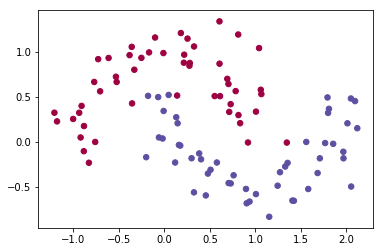

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = datasets.make_moons(100, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Spectral)

## 1. Logistic Regression: Single Layer NNet

First let's test Logistic Regression classifier as baseline estimator

In [5]:
# Train the logistic rgeression classifier
clf = linear_model.LogisticRegressionCV(cv=5)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Text(0.5, 1.0, 'Logistic Regression')

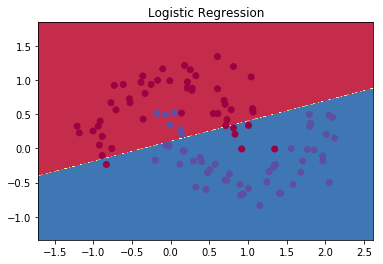

In [6]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

## 2. Neural Network from Scratch
Implementing a network from scratch at least once is an extremely valuable exercise. It helps you gain an understanding of how neural networks work, and that is essential to designing effective models.

Design of our neural architecture: 
* 2-layers neural network: 1-input layer, 1-hidden layer, and 1-output layer.
* Nombre of nodes: 2(=dim of data) nodes for input layer, 2(=nombre of classes) nodes for output (can use only 1 output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later)
* Free to choose the number of nodes of the hidden layer. More nodes into the hidden layer decribs more complex functions to fit data. But more computations and risk of overfitting. Good choice of the size of hidden layer always depends on your specific problem.
* Pick an activation function for our hidden layer. Nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are tanh, the sigmoid function, or ReLUs. tanh performs quite well in many scenarios and has nice derivative property: $\tanh x$ is $1-\tanh^2 x$
* Pick activation function for the output to to output probabilities. softmax converts raw scores to probabilities

In [7]:
# training set size
num_examples = len(X) 
# Paramater of the network
nn_input_dim = 2  # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
#nn_hdim: Number of nodes in the hidden layer (will be defined later as function parameter)
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

◊ Function to predict an output via Forward propagation

In [8]:
def predict(model, x):
    """
        Function to predict an output (0 or 1)
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

◊ Loss function to evaluate how well our model 

In [9]:
def calculate_loss(model):
    """
        Function to evaluate the total loss on the dataset
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

◊ Function to train the Neural Network. It implements batch gradient descent using the backpropagation derivates.

In [10]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    """
        Function to learn parameters for the neural network and returns the model.
        - nn_hdim: Number of nodes in the hidden layer
        - num_passes: Number of passes through the training data for gradient descent
        - print_loss: If True, print the loss every 1000 iterations
    """
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### Train a network with a hidden layer size of 2.

Loss after iteration 0: 0.680410
Loss after iteration 1000: 0.096035
Loss after iteration 2000: 0.075655
Loss after iteration 3000: 0.066073
Loss after iteration 4000: 0.095101
Loss after iteration 5000: 0.061627
Loss after iteration 6000: 0.069179
Loss after iteration 7000: 0.062163
Loss after iteration 8000: 0.072644
Loss after iteration 9000: 0.068586
Loss after iteration 10000: 0.296198
Loss after iteration 11000: 0.264716
Loss after iteration 12000: 0.063144
Loss after iteration 13000: 0.062224
Loss after iteration 14000: 0.213602
Loss after iteration 15000: 0.430947
Loss after iteration 16000: 0.067298
Loss after iteration 17000: 0.349531
Loss after iteration 18000: 0.062546
Loss after iteration 19000: 0.263286


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 2')

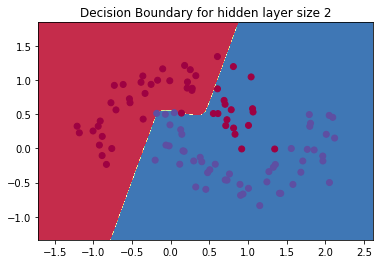

In [11]:
# Build a model with a 3-dimensional hidden layer
model = build_model(nn_hdim=2, print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 2")

### Tune the size of hidden layer

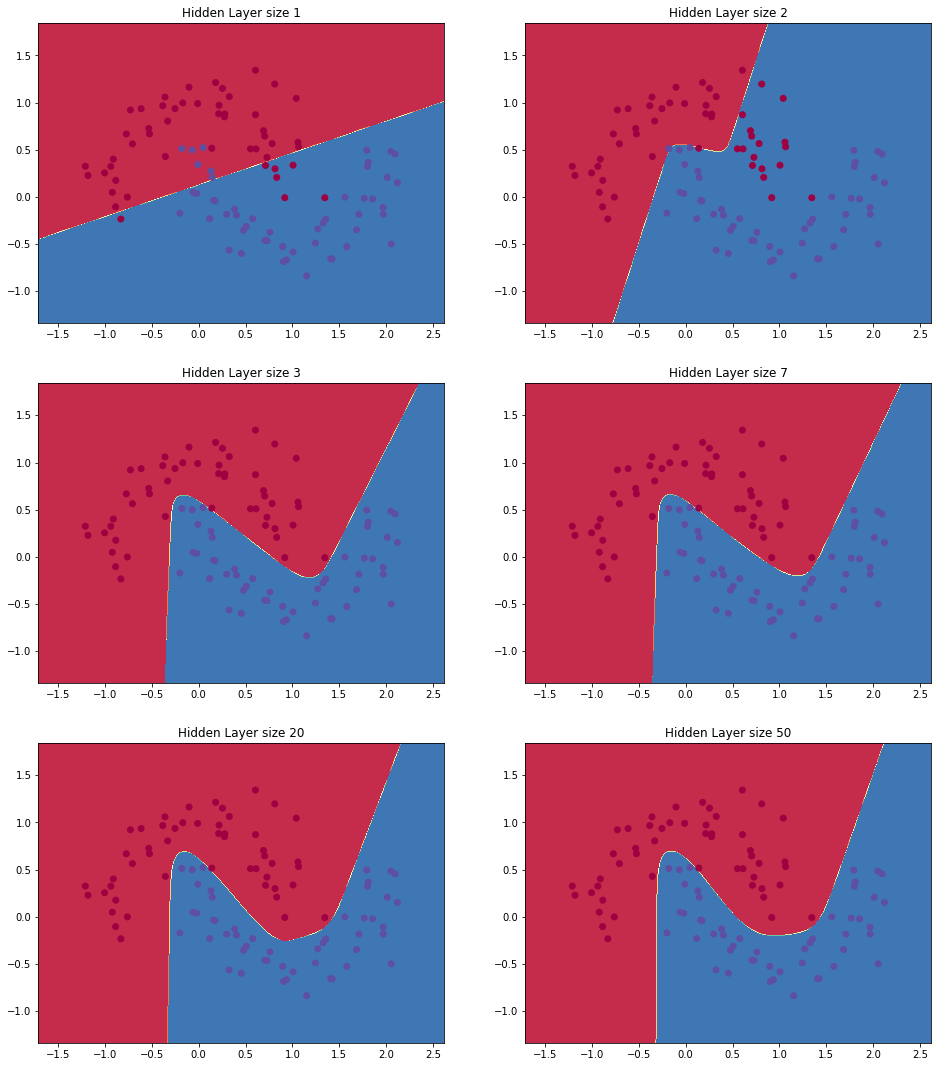

In [12]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 7, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

Conclusion ?